# Imports

In [0]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from os.path import join

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data processing

In [0]:
from google.colab import drive
path = "/content/gdrive/My Drive/Colab Notebooks/"
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/tsp_20_test.txt .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# copied from https://github.com/keon/pointer-networks/blob/master/tsp_data.py

import math
import numpy as np
import random
import itertools
from sklearn.model_selection import train_test_split

class Tsp:
    def next_batch(self, batch_size=1):
        X, Y = [], []
        for b in range(batch_size):
#             print("preparing dataset... %s/%s" % (b, batch_size))
            points = self.generate_data()
            solved = self.solve_tsp_dynamic(points)
            X.append(points), Y.append(solved)
        return np.asarray(X), np.asarray(Y)

    def length(self, x, y):
        return (math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2))

    def solve_tsp_dynamic(self, points):
        # calc all lengths
        all_distances = [[self.length(x, y) for y in points] for x in points]
        # initial value - just distance from 0 to
        # every other point + keep the track of edges
        A = {(frozenset([0, idx+1]), idx+1): (dist, [0, idx+1])
             for idx, dist in enumerate(all_distances[0][1:])}
        cnt = len(points)
        for m in range(2, cnt):
            B = {}
            for S in [frozenset(C) | {0}
                      for C in itertools.combinations(range(1, cnt), m)]:
                for j in S - {0}:
                    B[(S, j)] = min([(A[(S-{j}, k)][0] + all_distances[k][j],
                                      A[(S-{j}, k)][1] + [j])
                                     for k in S if k != 0 and k != j])
            A = B
        res = min([(A[d][0] + all_distances[0][d[1]], A[d][1])
                   for d in iter(A)])
        return res[1]

    def generate_data(self, N=10):
        radius = 1
        rangeX = (0, 10)
        rangeY = (0, 10)
        qty = N

        deltas = set()
        for x in range(-radius, radius+1):
            for y in range(-radius, radius+1):
                if x*x + y*y <= radius*radius:
                    deltas.add((x, y))

        randPoints = []
        excluded = set()
        i = 0
        while i < qty:
            x = random.randrange(*rangeX)
            y = random.randrange(*rangeY)
            if (x, y) in excluded:
                continue
            randPoints.append((x, y))
            i += 1
            excluded.update((x+dx, y+dy) for (dx, dy) in deltas)
        return randPoints
    
def read_from_file():
    with open("tsp_20_test.txt") as file:
        X = []
        Y = []

        for line in file:
            x, y = line.strip().split(" output ")
            x = x.strip().split()
            x = [float(i) for i in x]
            x = [[x[i], x[i+1]] for i in range(0,len(x)-1,2)]
            y = y.strip().split()
            y = [int(i)-1 for i in y[:-1]]
            X.append(x)
            Y.append(y)
        X = np.array(X)
        Y = np.array(Y)
        return X, Y
    
 
    
p = Tsp()
X, Y = p.next_batch(1000)
# X, Y = read_from_file()
# X, Y = X[:100], Y[:100]
print(X.shape, Y.shape)


(1000, 10, 2) (1000, 10)


In [0]:
class TSPDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.data_size = X.shape[0]
        self.label_size = Y.shape[1]
        
    def __len__(self):
        return self.data_size
    def __getitem__(self, idx):
        input_tensor = torch.from_numpy(self.X[idx]).float()   
        target_tensor = torch.from_numpy(self.Y[idx]).long()

        return input_tensor, target_tensor

tspdataset = TSPDataset(X, Y)

# Model

In [0]:
class Encoder_GRU(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Encoder_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.relu = nn.ReLU()
        self.n_layers = 1

        
        self.embedding = nn.Linear(2, self.hidden_size)
        self.rnn = nn.GRU(self.hidden_size, self.hidden_size)
        self.h_x = nn.Parameter(torch.zeros(1), requires_grad=False)
        
    def forward(self, input, hidden):
        embedded = self.relu(self.embedding(input)).permute(1, 0, 2)
        output, hidden = self.rnn(embedded, hidden)
        return output.permute(1,0,2) , hidden, embedded.permute(1,0,2)
    
    def init_hidden(self):
        h_x = self.h_x.unsqueeze(0).unsqueeze(0).repeat(self.n_layers, self.batch_size, self.hidden_size)

        return h_x

class Encoder_LSTM(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Encoder_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.relu = nn.ReLU()
        self.n_layers = 1
        
        self.embedding = nn.Linear(2, self.hidden_size)
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        
        self.c_x = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.h_x = nn.Parameter(torch.zeros(1), requires_grad=False)
        
    def forward(self, input, hidden, context):
        embedded = self.relu(self.embedding(input)).permute(1, 0, 2)
        output, (hidden, context) = self.rnn(embedded, (hidden, context))
        return output.permute(1,0,2) , hidden, embedded.permute(1,0,2), context
    
    def init_hidden(self):
        c_x = self.c_x.unsqueeze(0).unsqueeze(0).repeat(self.n_layers, self.batch_size, self.hidden_size)
        h_x = self.h_x.unsqueeze(0).unsqueeze(0).repeat(self.n_layers, self.batch_size, self.hidden_size)

        return h_x, c_x

class Attention_GRU(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_GRU, self).__init__()
        self.hidden_size = hidden_size
        
        self.W_hidden = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_encoded = nn.Linear(self.hidden_size, self.hidden_size)
        self.V = nn.Parameter(torch.FloatTensor(self.hidden_size), requires_grad=True)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.uniform_(self.V, -1, 1)
    
    def forward(self, input, hidden):
        encoder_outputs = self.W_encoded(input).permute(1,0,2)
        hidden = self.W_hidden(hidden)
        summed = self.tanh(encoder_outputs + hidden).permute(0,2,1)
        V = self.V.unsqueeze(0).expand(summed.size(0), -1).unsqueeze(1)
        attn_weights = torch.bmm(V, summed).squeeze().permute(1,0)
        alpha = self.softmax(attn_weights).unsqueeze(1)
        ct = torch.bmm(alpha, input).squeeze()
        return alpha.squeeze(), ct, attn_weights

class Attention_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        
        self.W_encoded = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_hidden_context = nn.Linear(self.hidden_size * 1, self.hidden_size)
        self.W_average = nn.Linear(self.n_layers, 1)
        self.V = nn.Parameter(torch.FloatTensor(self.hidden_size), requires_grad=True)
        self._inf = nn.Parameter(torch.FloatTensor([float('-inf')]), requires_grad=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.uniform_(self.V, -1, 1)
    
    def forward(self, input, hidden, context, mask):
        encoder_outputs = self.W_encoded(input).permute(1,0,2)
#         hidden_context = torch.cat((hidden, context), dim=2)
        hidden_context = hidden
        hidden_context = self.W_hidden_context(hidden_context)
#         hidden_context = torch.mean(hidden_context, dim=0)
        hidden_context = hidden_context.permute(2,1,0)
        hidden_context = self.W_average(hidden_context).permute(2,1,0)
        summed = self.tanh(encoder_outputs + hidden_context).permute(0,2,1)
        V = self.V.unsqueeze(0).expand(summed.size(0), -1).unsqueeze(1)
        attn_weights = torch.bmm(V, summed).squeeze().permute(1,0)
        if (len(attn_weights[mask]) > 0):
            attn_weights[mask] = self.inf[mask]
        alpha = self.softmax(attn_weights).unsqueeze(1)
        ct = torch.bmm(alpha, input).squeeze()
        return alpha.squeeze(), ct, attn_weights
    
    def init_inf(self, size):
        self.inf = self._inf.unsqueeze(1).expand(*size)
        
    
class Decoder_GRU(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder_GRU, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(self.hidden_size*2, self.hidden_size)
        self.attention = Attention_GRU(self.hidden_size)
        
    def forward(self, input, hidden, encoder_outputs, embedded):
        outputs = []
        pointers = []
                
        for _ in range(encoder_outputs.size(1)):
            alpha, ct, attn_weights = self.attention(encoder_outputs, hidden)
            w = torch.cat((input, ct),1).unsqueeze(0)
            _, hidden = self.rnn(w, hidden)
            _, topi = alpha.topk(1)
            topi = topi.squeeze().detach()
            input_ = []
            for j, i in enumerate(topi):
                input_.append(embedded[j,i,:].unsqueeze(0))
            input = torch.cat(input_)
            outputs.append(attn_weights)
            pointers.append(topi)
        
        return torch.stack(outputs,1), torch.stack(pointers,1)
        
class Decoder_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        
        self.rnn = nn.LSTM(self.hidden_size*2, self.hidden_size, self.n_layers)
        self.attention = Attention_LSTM(self.hidden_size)
        
        self.mask = nn.Parameter(torch.ones(1), requires_grad=False)
        
    def forward(self, input, hidden, encoder_outputs, embedded, context):
        outputs = []
        pointers = []
        
        mask = self.mask.repeat(encoder_outputs.size(1)).unsqueeze(0).repeat(encoder_outputs.size(0), 1)
        self.attention.init_inf(mask.size())
                
        for _ in range(encoder_outputs.size(1)):
            alpha, ct, attn_weights = self.attention(encoder_outputs, hidden, context, torch.eq(mask, 0))
            w = torch.cat((input, ct),1).unsqueeze(0)
            _, (hidden, context) = self.rnn(w, (hidden, context))
            
            masked_alpha = alpha * mask
            
            _, topi = masked_alpha.max(1)
            input_ = []
            for j, i in enumerate(topi):
                input_.append(embedded[j,i,:].unsqueeze(0))
                mask[j,i] = 0.
            input = torch.cat(input_)
            outputs.append(alpha)
            pointers.append(topi)
        
        return torch.stack(outputs,1), torch.stack(pointers,1)

class Pointer_GRU(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Pointer_GRU, self).__init__()
        self.encoder = Encoder_GRU(hidden_size, batch_size)
        self.decoder = Decoder_GRU(hidden_size)  
        self.decoder_input0 = nn.Parameter(torch.FloatTensor(batch_size, hidden_size), requires_grad=False)
        
        nn.init.uniform_(self.decoder_input0, -1, 1)
        
    def forward(self, input):
        eh0 = self.encoder.init_hidden()
        output, hidden, embedded = self.encoder(input, eh0)
        o, p = self.decoder(self.decoder_input0, hidden, output, embedded)
        return o, p
    
class Pointer_LSTM(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Pointer_LSTM, self).__init__()
        self.encoder = Encoder_LSTM(hidden_size, batch_size)
        self.decoder = Decoder_LSTM(hidden_size)  
        self.decoder_input0 = nn.Parameter(torch.FloatTensor(batch_size, hidden_size), requires_grad=False)
        
        nn.init.uniform_(self.decoder_input0, -1, 1)
        
    def forward(self, input):
        eh0, ec0 = self.encoder.init_hidden()
        output, hidden, embedded, context = self.encoder(input, eh0, ec0)
        o, p = self.decoder(self.decoder_input0, hidden, output, embedded, context)
        return o, p
        
    

# GRU Training


In [0]:
batch_size = 50
dataloader = DataLoader(tspdataset, batch_size=batch_size, shuffle=True, num_workers=4)

hidden_size = 256

pointer_net = Pointer_GRU(hidden_size, batch_size)

if torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
    pointer_net.cuda()
    net = torch.nn.DataParallel(pointer_net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
else:
    print("Not using GPU")
    USE_CUDA = False
    
lr = 1e-3
    
CCE = torch.nn.CrossEntropyLoss()
pointer_optim = optim.RMSprop(filter(lambda p: p.requires_grad,
                            pointer_net.parameters()),
                     lr=lr)
    
def train(epochs=10, step=1000, name="model"):
    losses = []
    batch_accs = []
    eps = []
    Dist = []
    
    for epoch in range(epochs):
        for j, (input_tensor, target_tensor) in enumerate(dataloader):
           
            if USE_CUDA:
                input_tensor = input_tensor.cuda()
                target_tensor = target_tensor.cuda()

            o, p = pointer_net(input_tensor)
            loss = CCE(o, target_tensor)
                        
            if ((len(dataloader))*(epoch) + (j+1)) % step == 0:
                
                compare = target_tensor == p
                acc_sum = compare.sum(dim=1)
                correct = 0.
                dist = compare[compare == 0].size()[0]
                for i in range(batch_size):
                    if acc_sum[i].item() == target_tensor.size(1):
                        correct += 1
                acc = correct / batch_size * 100
                batch_accs.append(acc)
                losses.append(loss.item())
                eps.append((epoch+1))
                Dist.append(dist)
                print("epoch {}: batch: {}/{} dist: {} loss: {}".format(epoch+1,j+1,len(dataloader),dist,loss.item()), p[0], target_tensor[0])
                to_save = {"pointer_net_state_dict" : pointer_net.state_dict(), "pointer_optim_state_dict" : pointer_optim.state_dict(), "epoch" : epoch, "j" : j}
                torch.save(to_save, join(path, "pointer_net_"+name+"_"+str(epoch)+".pt"))
            
            pointer_optim.zero_grad()
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(pointer_net.parameters(), 0.5)
            pointer_optim.step()
            
#     for l, a in zip(losses, batch_accs):
#         print(l,a)
    return losses, eps, Dist

losses_gru, epochs_gru, dist_gru = train(100, step=20*2, name="gru")
            

Using GPU, 1 devices.
epoch 2: batch: 20/20 dist: 398 loss: 1.9843437671661377 tensor([0, 1, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0') tensor([0, 1, 9, 4, 6, 3, 2, 8, 7, 5], device='cuda:0')
epoch 4: batch: 20/20 dist: 396 loss: 1.9737744331359863 tensor([0, 2, 4, 7, 7, 7, 7, 7, 7, 7], device='cuda:0') tensor([0, 1, 4, 3, 9, 8, 5, 7, 6, 2], device='cuda:0')
epoch 6: batch: 20/20 dist: 400 loss: 1.9741313457489014 tensor([0, 1, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0') tensor([0, 3, 4, 6, 1, 2, 9, 7, 8, 5], device='cuda:0')
epoch 8: batch: 20/20 dist: 402 loss: 1.9754364490509033 tensor([0, 2, 2, 2, 7, 7, 7, 7, 7, 7], device='cuda:0') tensor([0, 6, 9, 1, 4, 5, 8, 3, 2, 7], device='cuda:0')
epoch 10: batch: 20/20 dist: 401 loss: 1.9734270572662354 tensor([0, 2, 3, 3, 8, 8, 8, 8, 8, 8], device='cuda:0') tensor([0, 7, 9, 1, 6, 5, 3, 8, 2, 4], device='cuda:0')
epoch 12: batch: 20/20 dist: 405 loss: 1.9719921350479126 tensor([0, 1, 1, 1, 3, 3, 4, 4, 4, 4], device='cuda:0') tensor([0, 6, 4, 7

# LSTM Training

In [0]:
batch_size = 50
dataloader = DataLoader(tspdataset, batch_size=batch_size, shuffle=True, num_workers=4)

hidden_size = 256

pointer_net = Pointer_LSTM(hidden_size, batch_size)

if torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
    pointer_net.cuda()
    net = torch.nn.DataParallel(pointer_net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
else:
    print("Not using GPU")
    USE_CUDA = False
    
lr = 1e-3
    
CCE = torch.nn.CrossEntropyLoss()
pointer_optim = optim.RMSprop(filter(lambda p: p.requires_grad,
                            pointer_net.parameters()),
                     lr=lr)
    
def train(epochs=10, step=1000, name="model"):
    losses = []
    batch_accs = []
    eps = []
    Dist = []
    
    for epoch in range(epochs):
        for j, (input_tensor, target_tensor) in enumerate(dataloader):
           
            if USE_CUDA:
                input_tensor = input_tensor.cuda()
                target_tensor = target_tensor.cuda()

            o, p = pointer_net(input_tensor)
            loss = CCE(o, target_tensor)
                        
            if ((len(dataloader))*(epoch) + (j+1)) % step == 0:
                
                compare = target_tensor == p
                acc_sum = compare.sum(dim=1)
                correct = 0.
                dist = compare[compare == 0].size()[0]
                for i in range(batch_size):
                    if acc_sum[i].item() == target_tensor.size(1):
                        correct += 1
                acc = correct / batch_size * 100
                batch_accs.append(acc)
                losses.append(loss.item())
                eps.append((epoch+1))
                Dist.append(dist)
                print("epoch {}: batch: {}/{} dist: {} loss: {}".format(epoch+1,j+1,len(dataloader),dist,loss.item()), p[0], target_tensor[0])
                to_save = {"pointer_net_state_dict" : pointer_net.state_dict(), "pointer_optim_state_dict" : pointer_optim.state_dict(), "epoch" : epoch, "j" : j}
                torch.save(to_save, join(path, "pointer_net_"+name+"_"+str(epoch)+".pt"))
            
            pointer_optim.zero_grad()
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(pointer_net.parameters(), 0.5)
            pointer_optim.step()
            
#     for l, a in zip(losses, batch_accs):
#         print(l,a)

    return losses, eps, Dist

losses_lstm, epochs_lstm, dist_lstm = train(100, step=20*2, name="lstm_unmasked")
            

Using GPU, 1 devices.
epoch 2: batch: 20/20 dist: 398 loss: 2.208016872406006 tensor([0, 2, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0') tensor([0, 2, 5, 9, 3, 4, 8, 1, 7, 6], device='cuda:0')
epoch 4: batch: 20/20 dist: 398 loss: 2.2093985080718994 tensor([0, 1, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0') tensor([0, 3, 9, 8, 4, 1, 7, 2, 5, 6], device='cuda:0')
epoch 6: batch: 20/20 dist: 395 loss: 2.203101873397827 tensor([0, 6, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0') tensor([0, 2, 4, 3, 6, 5, 1, 9, 8, 7], device='cuda:0')
epoch 8: batch: 20/20 dist: 397 loss: 2.201049566268921 tensor([0, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0') tensor([0, 7, 9, 2, 4, 6, 3, 1, 8, 5], device='cuda:0')
epoch 10: batch: 20/20 dist: 391 loss: 2.1994447708129883 tensor([0, 1, 2, 3, 9, 9, 9, 9, 9, 9], device='cuda:0') tensor([0, 1, 2, 3, 7, 6, 5, 4, 8, 9], device='cuda:0')
epoch 12: batch: 20/20 dist: 394 loss: 2.1961591243743896 tensor([0, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0') tensor([0, 5, 2, 4, 3

In [0]:
torch.save(pointer_net.state_dict(), join(path,"masked_pointernet_final.pt"))


In [0]:
total_missed = 0.
total_dist = 0.

opt_total = 0.

dataloader = DataLoader(tspdataset, batch_size=batch_size, shuffle=True, num_workers=4)

for j, (input_tensor, target_tensor) in enumerate(dataloader):
           
    if USE_CUDA:
        input_tensor = input_tensor.cuda()
        target_tensor = target_tensor.cuda()

    o, p = pointer_net(input_tensor)
    
    print(input_tensor.size(), target_tensor.size())

    compare = target_tensor == p
    acc_sum = compare.sum(dim=1)
    dist = compare[compare == 0].size()[0]
    total_missed += dist
    
    tour_dist = 0.
    opt_dist = 0.
    
    for k in range(50):
#         print(input_tensor[k,])
        for i in range(19):

#             print(input_tensor[k,p[k,i],:], input_tensor[k,p[k,i+1],:])
#             print(p[k,i])
            x = torch.pow(input_tensor[k,p[k,i],0] - input_tensor[k,p[k,i+1],0],2)
            y = torch.pow(input_tensor[k,p[k,i],1] - input_tensor[k,p[k,i+1],1],2)
            td = torch.sqrt(x + y)
            
            x_opt = torch.pow(input_tensor[k,target_tensor[k,i],0] - input_tensor[k,target_tensor[k,i+1],0],2)
            y_opt = torch.pow(input_tensor[k,target_tensor[k,i],1] - input_tensor[k,target_tensor[k,i+1],1],2)
            td_opt = torch.sqrt(x_opt + y_opt)
#             print(td)

            tour_dist += td
            opt_dist += td_opt
        
    total_dist += tour_dist
    opt_total += opt_dist
    
print(total_dist / (50. * len(dataloader)))
print(opt_total / (50. * len(dataloader)))

torch.Size([50, 20, 2]) torch.Size([50, 20])
torch.Size([50, 20, 2]) torch.Size([50, 20])
tensor(8.6708, device='cuda:0')
tensor(4.0439, device='cuda:0')


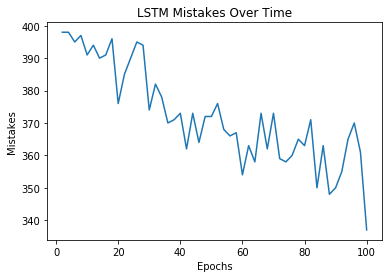

In [0]:
X = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000]
Y = [2.1689043045043945, 2.049980878829956, 1.8807538747787476, 1.8862016201019287, 1.872876763343811, 1.8428858518600464, 1.7948155403137207, 1.7852349281311035, 1.8030064105987549, 1.7452983856201172, 1.761432409286499, 1.7307560443878174, 1.755123257637024, 1.7456105947494507, 1.7584829330444336, 1.7238335609436035, 1.7694389820098877, 1.6829913854599, 1.7074567079544067, 1.731794834136963, 1.6763498783111572, 1.7016667127609253, 1.647472620010376, 1.684429407119751, 1.6404321193695068]

import matplotlib.pyplot as plt

plt.ylabel('Mistakes')
plt.xlabel('Epochs')
plt.title('LSTM Mistakes Over Time')
plt.plot(epochs_lstm,dist_lstm)
